In [1]:
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
import harmonica as hm
import xrft

import pyproj
import pygmt

import euler

import warnings

warnings.filterwarnings("ignore")

In [2]:
# The data are in a pandas.DataFrame
data = vd.datasets.fetch_rio_magnetic()
data.head()

longitude   latitude  total_field_anomaly_nt  height_ell_m line_type  \
0 -42.590424 -22.499878                  115.41        264.26      LINE   
1 -42.590485 -22.498978                  121.35        265.48      LINE   
2 -42.590530 -22.498077                  128.29        263.96      LINE   
3 -42.590591 -22.497177                  133.24        258.47      LINE   
4 -42.590652 -22.496277                  136.18        252.07      LINE   

   line_number  
0         2902  
1         2902  
2         2902  
3         2902  
4         2902

### Project coordinates

In [3]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)
coordinates = (easting, northing, data.height_ell_m)

data = data.assign(easting_m=easting)
data = data.assign(northing_m=northing)
data

longitude   latitude  total_field_anomaly_nt  height_ell_m line_type  \
0     -42.590424 -22.499878                  115.41        264.26      LINE   
1     -42.590485 -22.498978                  121.35        265.48      LINE   
2     -42.590530 -22.498077                  128.29        263.96      LINE   
3     -42.590591 -22.497177                  133.24        258.47      LINE   
4     -42.590652 -22.496277                  136.18        252.07      LINE   
...          ...        ...                     ...           ...       ...   
37713 -42.023544 -22.073761                    6.20        269.75       TIE   
37714 -42.024536 -22.073776                   16.26        263.96       TIE   
37715 -42.025513 -22.073776                   30.33        255.73       TIE   
37716 -42.026505 -22.073776                   46.39        247.19       TIE   
37717 -42.027496 -22.073776                   61.45        240.49       TIE   

       line_number     easting_m    northing_m  
0             2902 -4.390282e+06 -2.366202e+06  
1             2902 -4.390289e+06 -2.366102e+06  
2             2902 -4.390293e+06 -2.366002e+06  
3             2902 -4.390300e+06 -2.365902e+06  
4             2902 -4.390306e+06 -2.365802e+06  
...            ...           ...           ...  
37713         9600 -4.331848e+06 -2.319003e+06  
37714         9600 -4.331950e+06 -2.319005e+06  
37715         9600 -4.332051e+06 -2.319005e+06  
37716         9600 -4.332153e+06 -2.319005e+06  
37717         9600 -4.332255e+06 -2.319005e+06  

[37718 rows x 8 columns]

In [4]:
region_degrees = [
    data.longitude.min(),
    data.longitude.max(),
    data.latitude.min(),
    data.latitude.max(),
]
region_meters = [
    data.easting_m.min(),
    data.easting_m.max(),
    data.northing_m.min(),
    data.northing_m.max(),
]

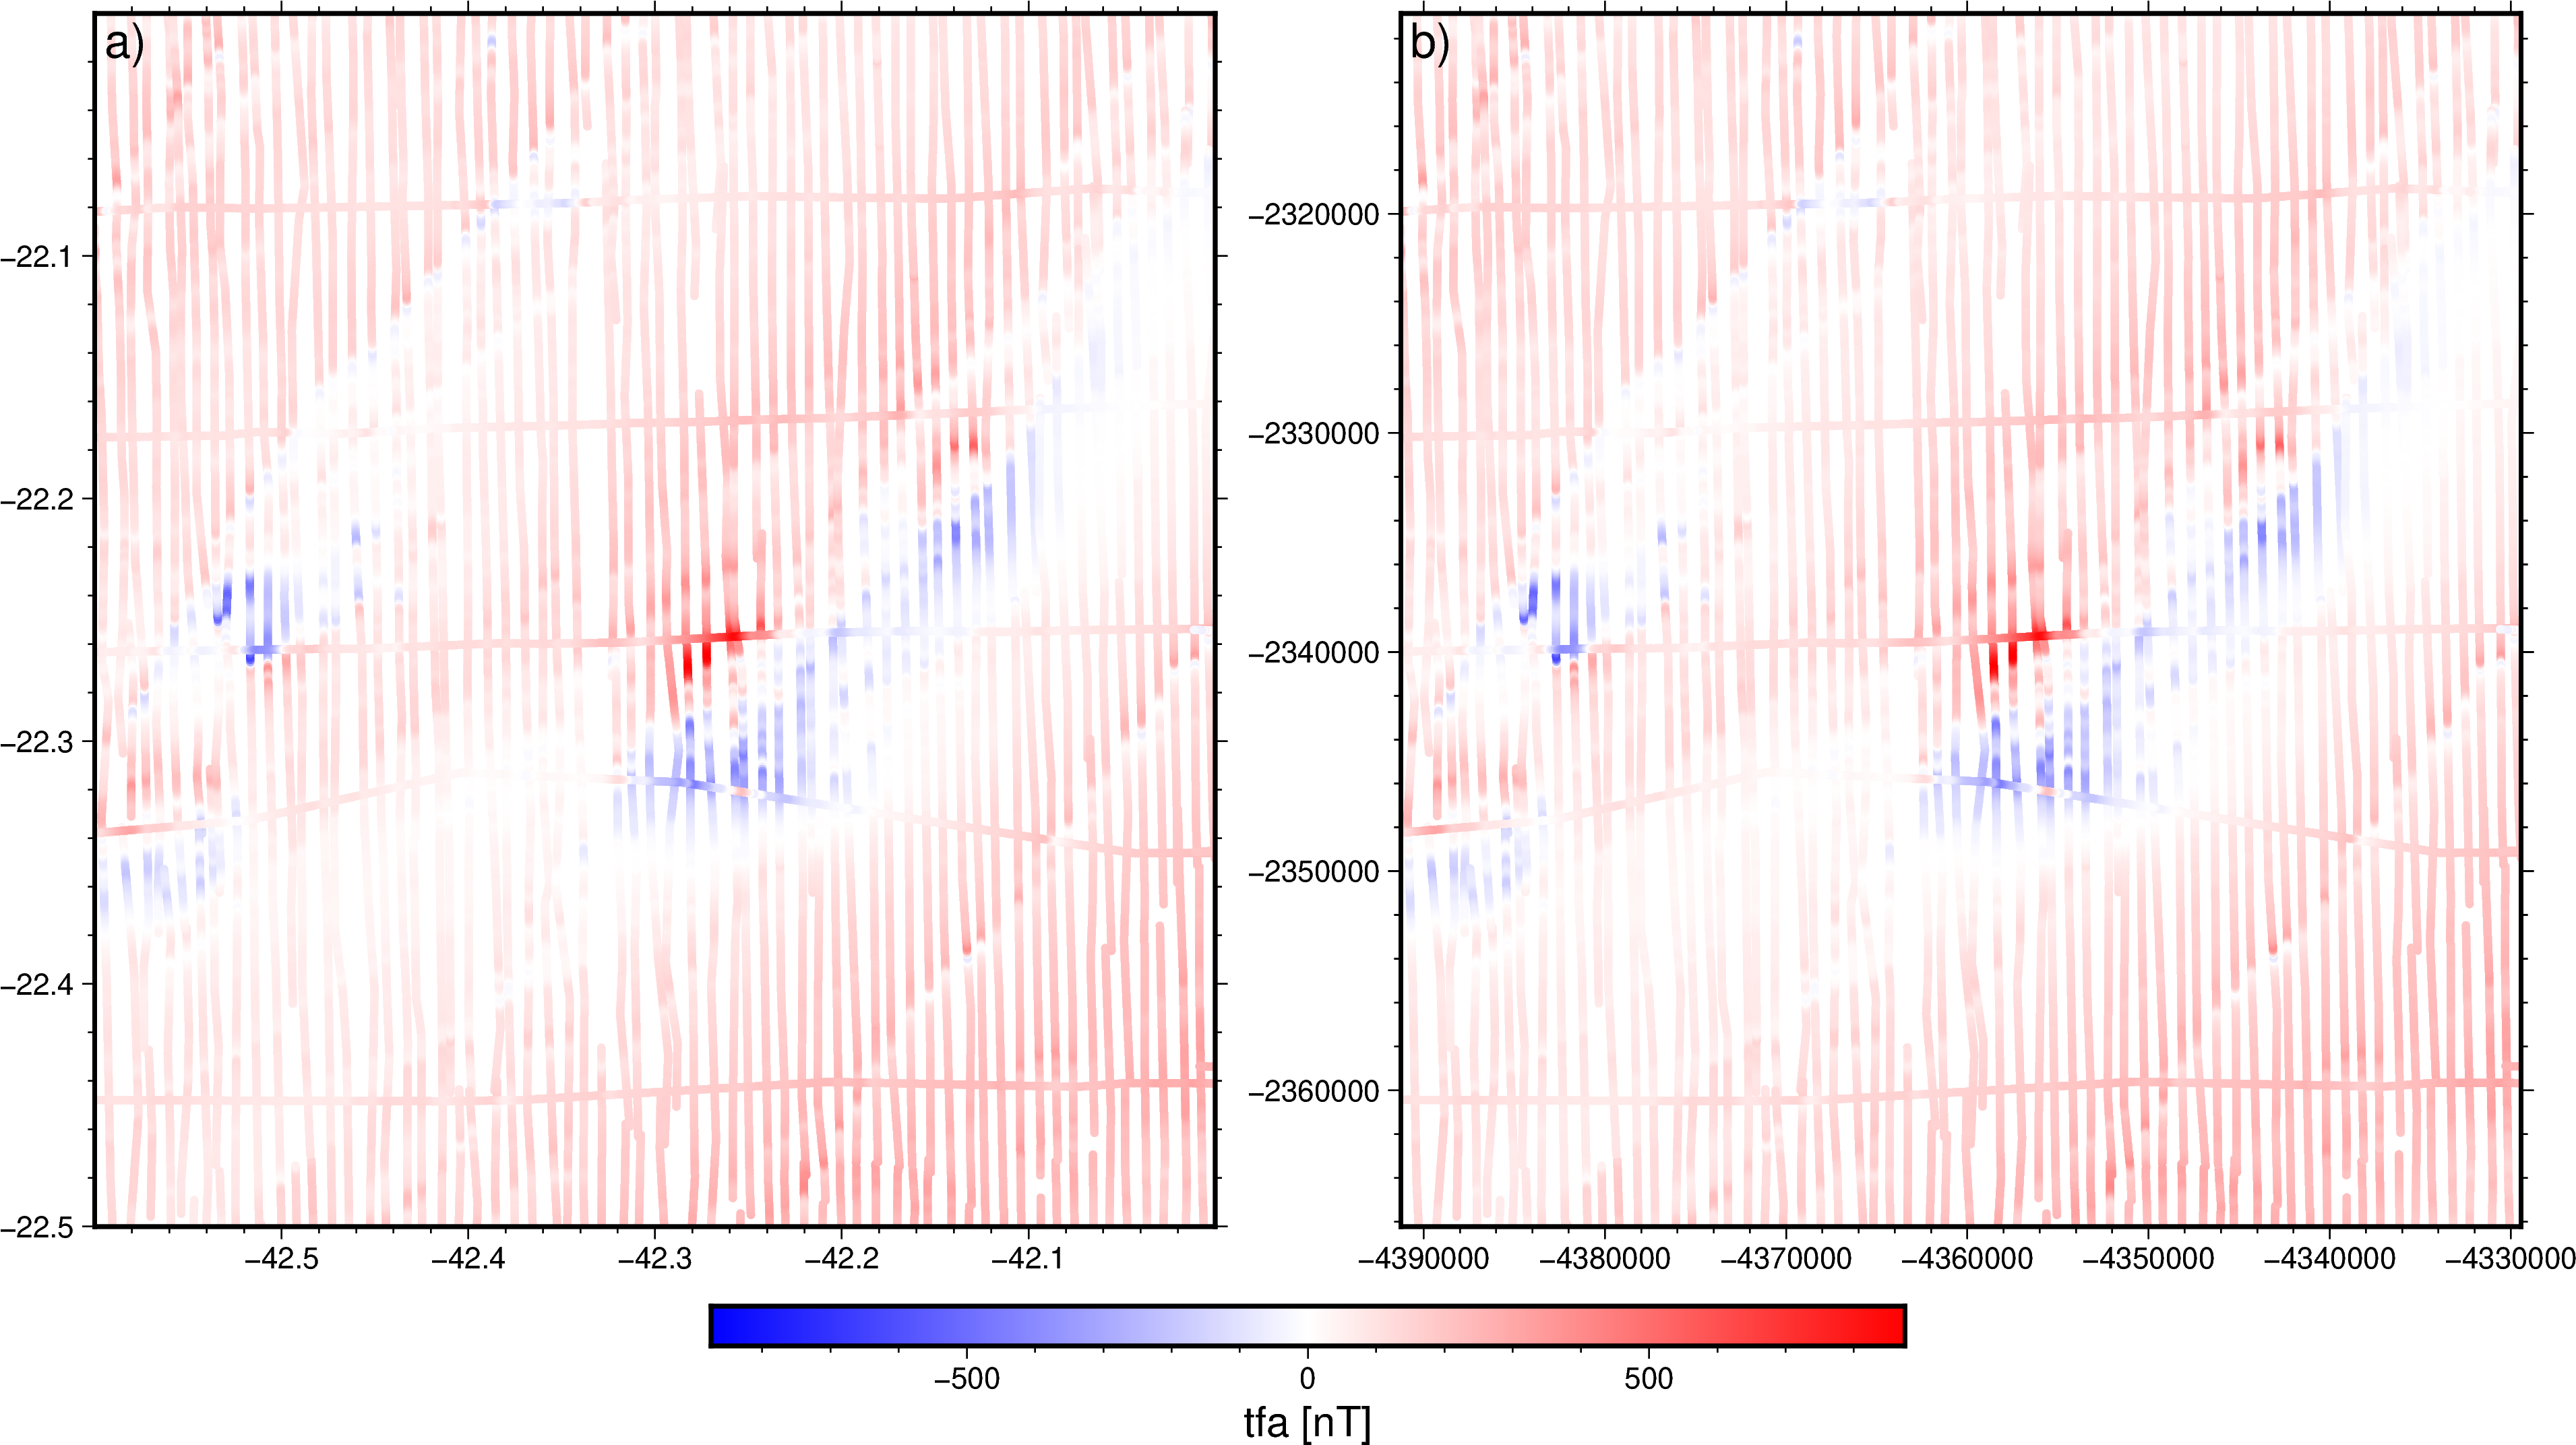

In [5]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.total_field_anomaly_nt)
pygmt.makecpt(cmap="polar+h", series=[-maxabs, maxabs])
with fig.subplot(
    nrows=1, ncols=2, figsize=("12i", "6i"), autolabel=True, margins="0.9c"
):
    with fig.set_panel(panel=0):
        pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
        fig.plot(
            x=data.longitude,
            y=data.latitude,
            fill=data.total_field_anomaly_nt,
            cmap=True,
            style="c0.1c",
            frame=["WSne", "xaf", "yaf"],
            region=region_degrees,
        )

    with fig.set_panel(panel=1):
        pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
        fig.plot(
            x=data.easting_m,
            y=data.northing_m,
            fill=data.total_field_anomaly_nt,
            cmap=True,
            style="c0.1c",
            frame=["WSne", "xaf", "yaf"],
            region=region_meters,
        )
fig.colorbar(
    position="JBC+o0c/1c+w15c/0.5c", frame="af+ltfa [nT]"  # Adjust position and size
)
fig.show()

In [6]:
grid_spacing = 0.1e3

eqs = hm.EquivalentSourcesGB(
    depth=1.3e3, damping=10, block_size=grid_spacing, window_size=10e3, random_state=42
)

In [7]:
eqs.estimate_required_memory(coordinates)

np.int64(12503952)

In [8]:
eqs.fit(coordinates, data.total_field_anomaly_nt)

EquivalentSourcesGB(block_size=100.0, damping=10, depth=1300.0, random_state=42,
                    window_size=10000.0)

In [9]:
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=grid_spacing,
    extra_coords=data.height_ell_m.max(),
)
grid = eqs.grid(grid_coords, data_names=["tfa_nt"])
grid

<xarray.Dataset> Size: 6MB
Dimensions:   (northing: 555, easting: 619)
Coordinates:
  * easting   (easting) float64 5kB -4.391e+06 -4.391e+06 ... -4.329e+06
  * northing  (northing) float64 4kB -2.366e+06 -2.366e+06 ... -2.311e+06
    upward    (northing, easting) float64 3MB 300.0 300.0 300.0 ... 300.0 300.0
Data variables:
    tfa_nt    (northing, easting) float64 3MB 114.4 116.0 117.6 ... 159.3 161.3
Attributes:
    metadata:  Generated by EquivalentSourcesGB(block_size=100.0, damping=10,...

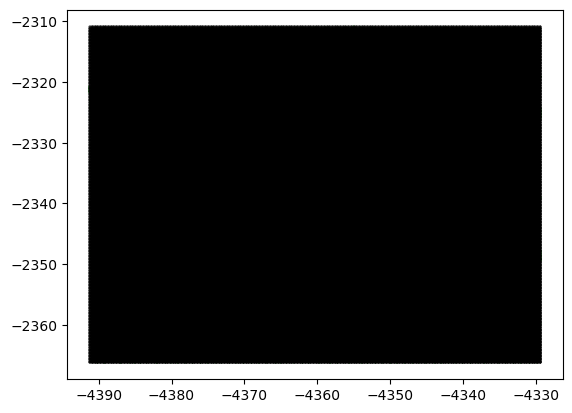

In [10]:
grid_table = vd.grid_to_table(grid)

plt.scatter(data.easting_m / 1.0e3, data.northing_m / 1.0e3, color="g", s=0.1)
plt.scatter(grid_table.easting / 1.0e3, grid_table.northing / 1.0e3, color="k", s=0.1)

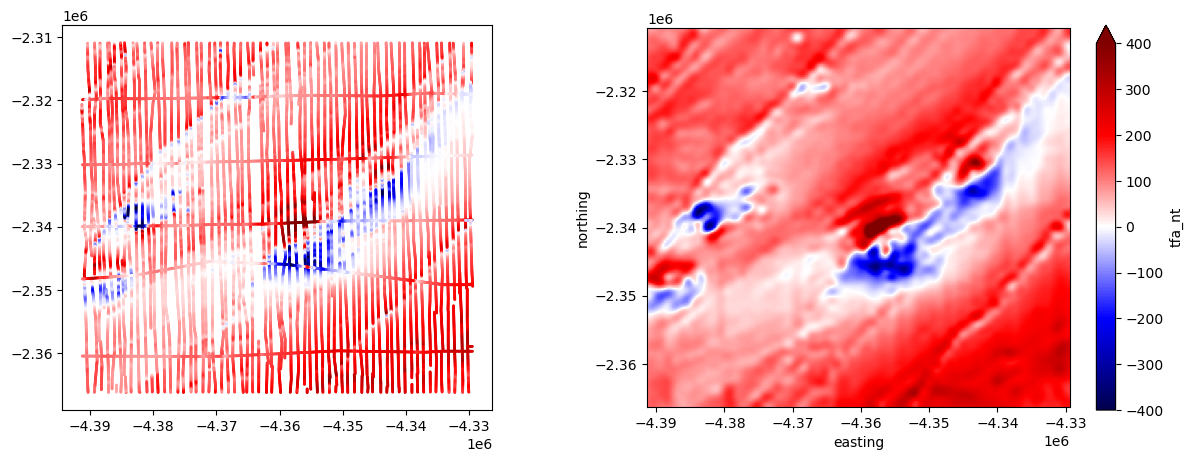

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.ravel()

ax = axes[0]
# maxabs = vd.maxabs(data.total_field_anomaly_nt)
ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.total_field_anomaly_nt,
    s=1,
    cmap="seismic",
    vmin=-400,
    vmax=400,
    # transform=crs,
)
ax.set_aspect("equal")

ax = axes[1]
tmp = grid.tfa_nt.plot.pcolormesh(cmap="seismic", vmax=400, vmin=-400)
ax.set_aspect("equal")

# Calculate the residual

In [12]:
# grid_check_table = vd.grid_to_table(grid_check)
# interpolator = vd.KNeighbors()
# interpolator.fit((grid_check_table.easting, grid_check_table.northing), grid_check_table.tfa_nt)
# data = data.assign(eqs_grid_tfa_nt=interpolator.predict((data.easting_m, data.northing_m)))
# data = data.assign(residual=data.total_field_anomaly_nt - data.eqs_grid_tfa_nt)
# data

In [13]:
tfa_predict = eqs.predict(coordinates)
data = data.assign(tfa_predict=tfa_predict)
data = data.assign(residual=data.total_field_anomaly_nt - tfa_predict)
data

longitude   latitude  total_field_anomaly_nt  height_ell_m line_type  \
0     -42.590424 -22.499878                  115.41        264.26      LINE   
1     -42.590485 -22.498978                  121.35        265.48      LINE   
2     -42.590530 -22.498077                  128.29        263.96      LINE   
3     -42.590591 -22.497177                  133.24        258.47      LINE   
4     -42.590652 -22.496277                  136.18        252.07      LINE   
...          ...        ...                     ...           ...       ...   
37713 -42.023544 -22.073761                    6.20        269.75       TIE   
37714 -42.024536 -22.073776                   16.26        263.96       TIE   
37715 -42.025513 -22.073776                   30.33        255.73       TIE   
37716 -42.026505 -22.073776                   46.39        247.19       TIE   
37717 -42.027496 -22.073776                   61.45        240.49       TIE   

       line_number     easting_m    northing_m  tfa_predict   residual  
0             2902 -4.390282e+06 -2.366202e+06   123.853080  -8.443080  
1             2902 -4.390289e+06 -2.366102e+06   125.555557  -4.205557  
2             2902 -4.390293e+06 -2.366002e+06   127.165865   1.124135  
3             2902 -4.390300e+06 -2.365902e+06   128.732428   4.507572  
4             2902 -4.390306e+06 -2.365802e+06   130.103838   6.076162  
...            ...           ...           ...          ...        ...  
37713         9600 -4.331848e+06 -2.319003e+06    24.731446 -18.531446  
37714         9600 -4.331950e+06 -2.319005e+06    30.158238 -13.898238  
37715         9600 -4.332051e+06 -2.319005e+06    34.839833  -4.509833  
37716         9600 -4.332153e+06 -2.319005e+06    38.559916   7.830084  
37717         9600 -4.332255e+06 -2.319005e+06    40.963840  20.486160  

[37718 rows x 10 columns]

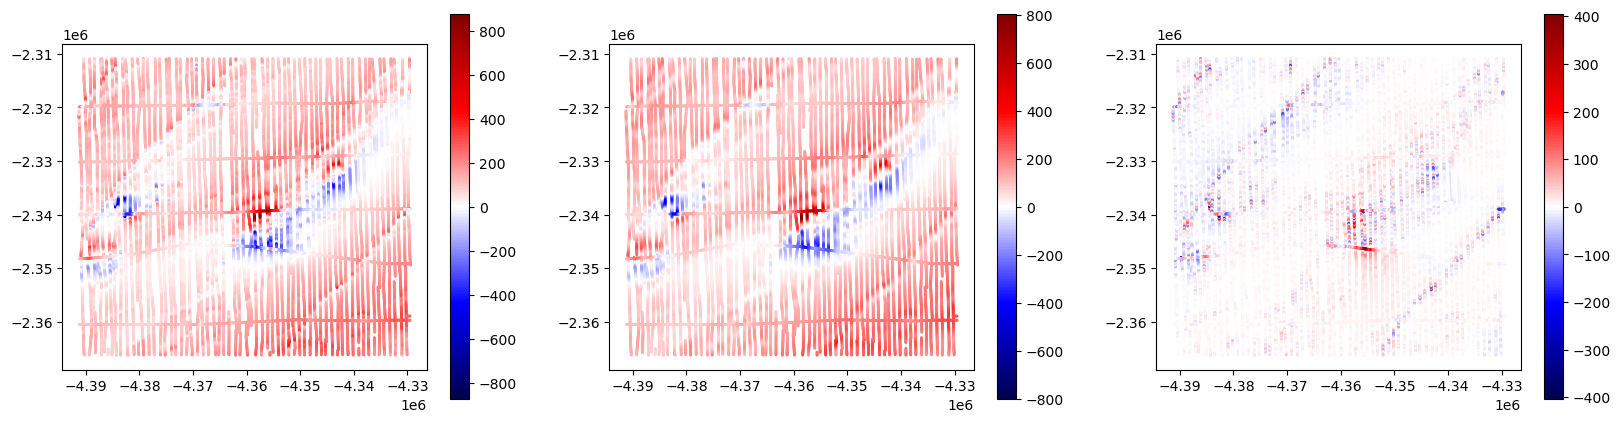

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)
scale = 400
# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

ax = axes[0]
tmp1 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.total_field_anomaly_nt,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.total_field_anomaly_nt),
    vmax=vd.maxabs(data.total_field_anomaly_nt),
)
plt.colorbar(tmp1, ax=ax)
ax.set_aspect("equal")

ax = axes[1]
tmp2 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.tfa_predict,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.tfa_predict),
    vmax=vd.maxabs(data.tfa_predict),
)
plt.colorbar(tmp2, ax=ax)
ax.set_aspect("equal")

ax = axes[2]
tmp3 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.residual,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.residual),
    vmax=vd.maxabs(data.residual),
)
plt.colorbar(tmp3, ax=ax)
ax.set_aspect("equal")

fig.show()

# fig.colorbar(tmp, **cbar_kwargs, label="tfa [nT]", cax=fig.add_axes([0.25, 0.05, 0.5, 0.01]))

# Calculate the derivatives

In [15]:
delta_h = 10
deast = (
    eqs.predict((coordinates[0] + delta_h, coordinates[1], coordinates[2]))
    - eqs.predict((coordinates[0] - delta_h, coordinates[1], coordinates[2]))
) / (2 * delta_h)


dnorth = (
    eqs.predict((coordinates[0], coordinates[1] + delta_h, coordinates[2]))
    - eqs.predict((coordinates[0], coordinates[1] - delta_h, coordinates[2]))
) / (2 * delta_h)


delta_v = 5
dup = (
    eqs.predict((coordinates[0], coordinates[1], coordinates[2] + delta_v))
    - eqs.predict((coordinates[0], coordinates[1], coordinates[2] - delta_v))
) / (2 * delta_v)

In [16]:
data = data.assign(easting_derivative=deast)
data = data.assign(northing_derivative=dnorth)
data = data.assign(upward_derivative=dup)
data

longitude   latitude  total_field_anomaly_nt  height_ell_m line_type  \
0     -42.590424 -22.499878                  115.41        264.26      LINE   
1     -42.590485 -22.498978                  121.35        265.48      LINE   
2     -42.590530 -22.498077                  128.29        263.96      LINE   
3     -42.590591 -22.497177                  133.24        258.47      LINE   
4     -42.590652 -22.496277                  136.18        252.07      LINE   
...          ...        ...                     ...           ...       ...   
37713 -42.023544 -22.073761                    6.20        269.75       TIE   
37714 -42.024536 -22.073776                   16.26        263.96       TIE   
37715 -42.025513 -22.073776                   30.33        255.73       TIE   
37716 -42.026505 -22.073776                   46.39        247.19       TIE   
37717 -42.027496 -22.073776                   61.45        240.49       TIE   

       line_number     easting_m    northing_m  tfa_predict   residual  \
0             2902 -4.390282e+06 -2.366202e+06   123.853080  -8.443080   
1             2902 -4.390289e+06 -2.366102e+06   125.555557  -4.205557   
2             2902 -4.390293e+06 -2.366002e+06   127.165865   1.124135   
3             2902 -4.390300e+06 -2.365902e+06   128.732428   4.507572   
4             2902 -4.390306e+06 -2.365802e+06   130.103838   6.076162   
...            ...           ...           ...          ...        ...   
37713         9600 -4.331848e+06 -2.319003e+06    24.731446 -18.531446   
37714         9600 -4.331950e+06 -2.319005e+06    30.158238 -13.898238   
37715         9600 -4.332051e+06 -2.319005e+06    34.839833  -4.509833   
37716         9600 -4.332153e+06 -2.319005e+06    38.559916   7.830084   
37717         9600 -4.332255e+06 -2.319005e+06    40.963840  20.486160   

       easting_derivative  northing_derivative  upward_derivative  
0               -0.006434             0.017914          -0.035059  
1               -0.006200             0.016215          -0.037270  
2               -0.005908             0.014224          -0.039200  
3               -0.005452             0.011978          -0.040932  
4               -0.004823             0.009472          -0.042179  
...                   ...                  ...                ...  
37713           -0.056222             0.042696          -0.012034  
37714           -0.048683             0.041610          -0.025017  
37715           -0.038909             0.039716          -0.035453  
37716           -0.027036             0.036888          -0.042411  
37717           -0.014226             0.033184          -0.044706  

[37718 rows x 13 columns]

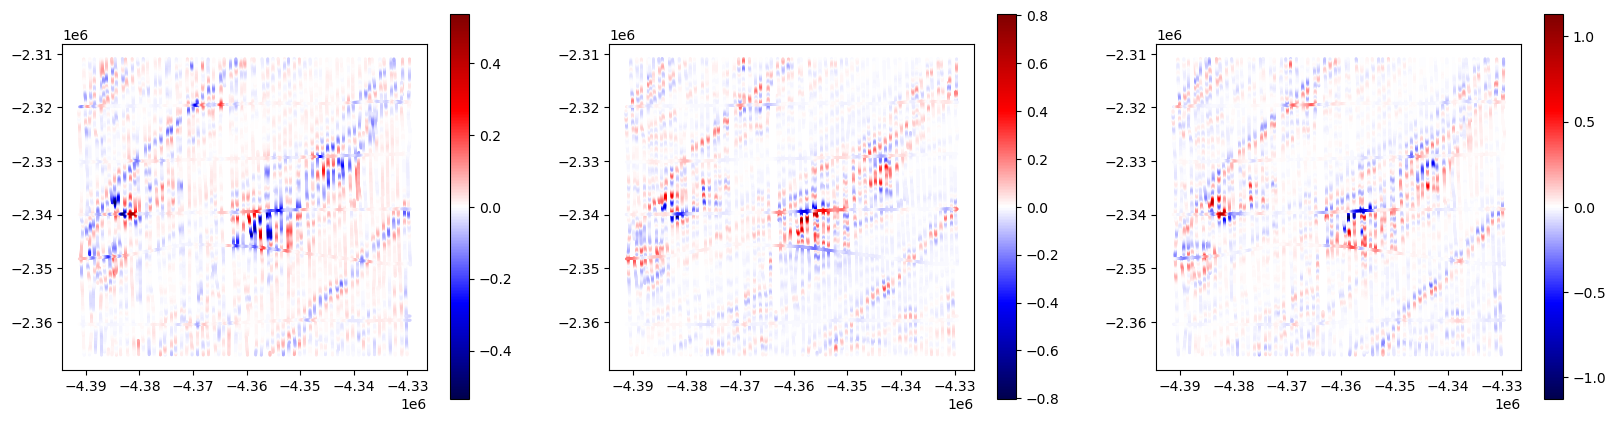

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)
scale = 400
# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

ax = axes[0]
tmp1 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.easting_derivative,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.easting_derivative),
    vmax=vd.maxabs(data.easting_derivative),
)
plt.colorbar(tmp1, ax=ax)
ax.set_aspect("equal")

ax = axes[1]
tmp2 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.northing_derivative,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.northing_derivative),
    vmax=vd.maxabs(data.northing_derivative),
)
plt.colorbar(tmp2, ax=ax)
ax.set_aspect("equal")

ax = axes[2]
tmp3 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.upward_derivative,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.upward_derivative),
    vmax=vd.maxabs(data.upward_derivative),
)
plt.colorbar(tmp3, ax=ax)
ax.set_aspect("equal")

fig.show()

# fig.colorbar(tmp, **cbar_kwargs, label="tfa [nT]", cax=fig.add_axes([0.25, 0.05, 0.5, 0.01]))

# Derivatives using grid

In [18]:
grid["deriv_east"] = hm.derivative_easting(grid.tfa_nt)
grid["deriv_north"] = hm.derivative_northing(grid.tfa_nt)


magnetic_grid_no_height = grid.drop_vars("upward")


pad_width = {
    "easting": grid.easting.size // 3,
    "northing": grid.northing.size // 3,
}


padded = xrft.pad(
    magnetic_grid_no_height.tfa_nt, pad_width, mode="linear_ramp", constant_values=None
)
grid["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)


grid = grid.assign(
    total_gradient=np.sqrt(grid.deriv_east**2 + grid.deriv_north**2 + grid.deriv_up**2)
)

grid

<xarray.Dataset> Size: 16MB
Dimensions:         (northing: 555, easting: 619)
Coordinates:
  * easting         (easting) float64 5kB -4.391e+06 -4.391e+06 ... -4.329e+06
  * northing        (northing) float64 4kB -2.366e+06 -2.366e+06 ... -2.311e+06
    upward          (northing, easting) float64 3MB 300.0 300.0 ... 300.0 300.0
Data variables:
    tfa_nt          (northing, easting) float64 3MB 114.4 116.0 ... 159.3 161.3
    deriv_east      (northing, easting) float64 3MB 0.0161 0.01573 ... 0.02
    deriv_north     (northing, easting) float64 3MB 0.01096 0.01173 ... -0.02435
    deriv_up        (northing, easting) float64 3MB 0.002527 ... -0.08353
    total_gradient  (northing, easting) float64 3MB 0.01964 0.02092 ... 0.08928
Attributes:
    metadata:  Generated by EquivalentSourcesGB(block_size=100.0, damping=10,...

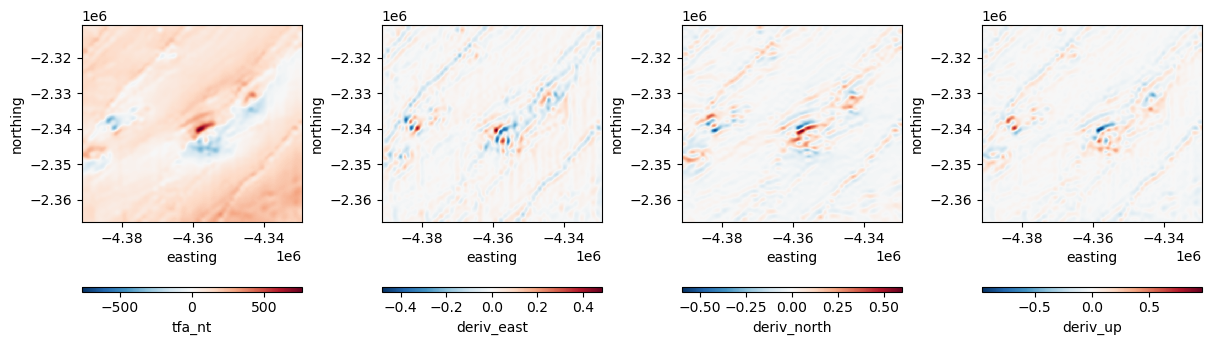

In [19]:
fig, axes = plt.subplots(1, 4, figsize=(12, 5), layout="constrained")
for field, ax in zip(["tfa_nt", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    grid[field].plot.pcolormesh(
        ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50)
    )
    ax.set_aspect("equal")
plt.show()

# Euler Deconvolution

In [20]:
window_size = 10e3
window_step = window_size / 4

In [21]:
%%time
deconvolutions = {}
for si in [1, 2, 3]:
    deconvolutions[si] = euler.EulerDeconvolutionWindowed(
        structural_index=si,
        window_size=window_size,
        window_step=window_step,
        keep=0.3,
    ).fit_grid(
        grid,
        data_names=("tfa_nt", "deriv_east", "deriv_north", "deriv_up"),
        coordinate_names=("easting", "northing", "upward"),
    )

CPU times: user 4.43 s, sys: 100 ms, total: 4.53 s
Wall time: 4.53 s


# Euler Inversion

In [22]:
%%time
ei = euler.EulerInversionWindowed(
    window_size=window_size,
    window_step=window_step,
    keep=0.10,
).fit_grid(
    grid,
    data_names=("tfa_nt", "deriv_east", "deriv_north", "deriv_up"),
    coordinate_names=("easting", "northing", "upward"),
)

CPU times: user 895 ms, sys: 183 ms, total: 1.08 s
Wall time: 58.3 s


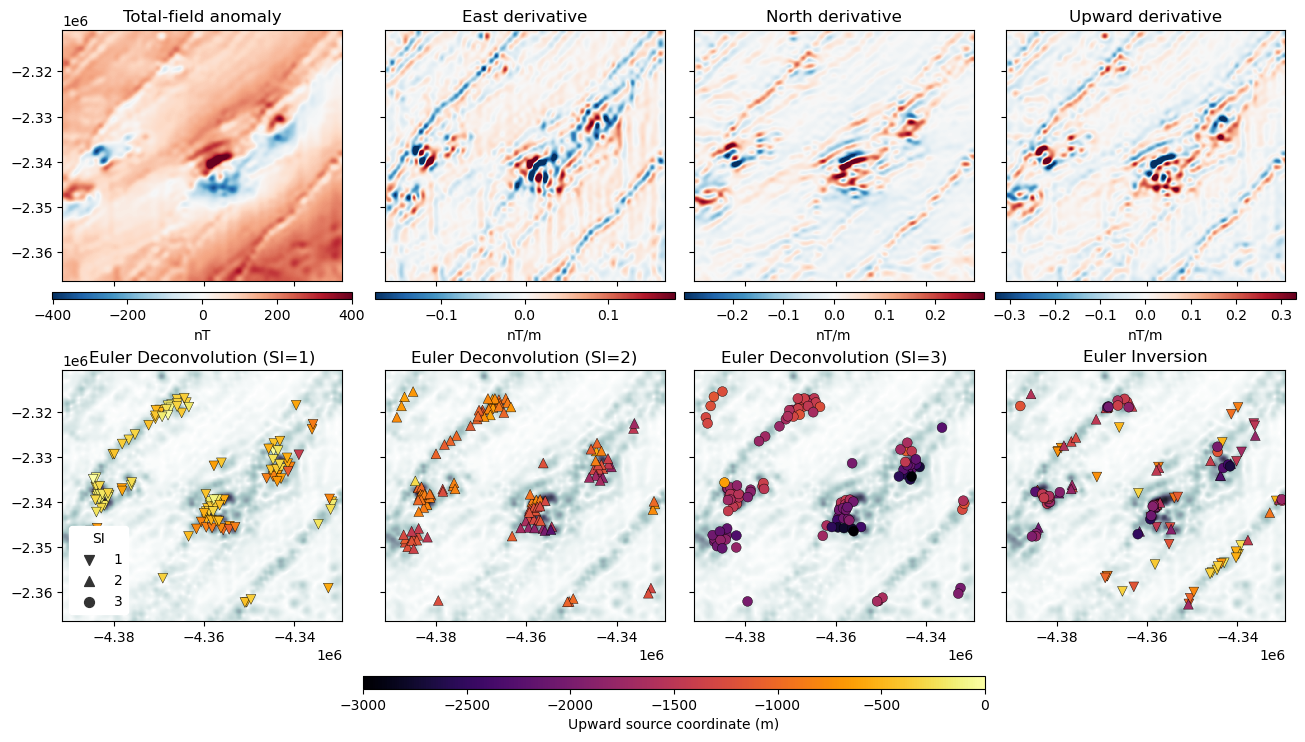

In [23]:
fig, axes = plt.subplots(
    2, 4, figsize=(13, 7.3), layout="constrained", sharey=True, sharex=True
)

subplot_labels = [f"{i})" for i in "abcdefgh"]
units = {
    "tfa_nt": "nT",
    "deriv_east": "nT/m",
    "deriv_north": "nT/m",
    "deriv_up": "nT/m",
}
data_names = {
    "tfa_nt": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}
markers = ["v", "^", "o"]
vmin, vmax = -3000, 0
size = 50


for field, ax in zip(["tfa_nt", "deriv_east", "deriv_north", "deriv_up"], axes[0, :]):
    ax.set_aspect("equal")
    scale = np.percentile(grid[field].values, 99.8)
    tmp = grid[field].plot.pcolormesh(
        ax=ax,
        add_colorbar=False,
        add_labels=False,
        vmax=scale,
        vmin=-scale,
        cmap="RdBu_r",
    )
    fig.colorbar(
        tmp, ax=ax, orientation="horizontal", aspect=40, pad=0.02, label=units[field]
    )
    ax.set_title(data_names[field])
ax = axes[0, 0]

scale = np.percentile(grid.total_gradient.values, 99.9)
for ax in axes[1, :]:
    ax.set_aspect("equal")
    grid.total_gradient.plot.pcolormesh(
        ax=ax, add_colorbar=False, add_labels=False, vmax=scale, vmin=0, cmap="bone_r"
    )

# Euler deconvolution
for si, marker, ax in zip([1, 2, 3], markers, axes[1, :-1]):
    ax.set_title(f"Euler Deconvolution (SI={si})")
    ax.scatter(
        *deconvolutions[si].locations_[:2],
        c=deconvolutions[si].locations_[2],
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.3,
        # cmap="tab20b",
        cmap="inferno",
    )

# Euler inversion
labels = {}
ax = axes[1, -1]
ax.set_title("Euler Inversion")
for si, marker in zip([1, 2, 3], markers):
    is_si = ei.structural_indices_ == si
    tmp = ax.scatter(
        *ei.locations_[:2, is_si],
        c=ei.locations_[2, is_si],
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.3,
        # cmap="tab20b",
        cmap="inferno",
    )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)

axes[1, 0].legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(
    tmp,
    ax=axes[1, :],
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)

# for ax, label in zip(axes.ravel(), subplot_labels):
#     ax.text(-0.05, 1.04, label, transform=ax.transAxes)
# for ax in axes[1, :]:
#     ax.set_xticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_yticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_ylabel("Northing (m)")
# for ax in axes[1, :]:
#     ax.set_xlabel("Easting (m)")